<a href="https://colab.research.google.com/github/rkn2/factorAnalysisExample/blob/master/FactorAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background on the problem


A wall in a building next to a river is deteriorating. What is causing it?

Below find an image of how the wall is situated in the building, where doors are, and where current sensors are located. 

**Your job is to look at the data coming from the sensors, and figure out what they are telling you.**

![alt text](https://drive.google.com/uc?id=1TWhPuLFF7pNcXlycMDmdDWlFxWQJq3DQ)



# Pre-processing our data


## Loading the data

This step just installs any packages we will need to run the analysis code. You don't have to worry about any specifics here.

In [1]:
# Import required libraries
import pandas as pd
from sklearn.datasets import load_iris
#!pip install factor_analyzer
!pip install factor_analyzer==0.2.3
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import numpy as np


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now we will load the data. This line reads in the comma separated value sheet that I made in excel.

If you are given sensor data in excel and want to export it to csv in the future, see this link:
https://www.ablebits.com/office-addins-blog/2014/04/24/convert-excel-csv/

In [0]:
url = 'https://raw.githubusercontent.com/rkn2/factorAnalysisExample/master/testDataSmall.csv' #you can change this link depending on your data
df = pd.read_csv(url)
#df= pd.read_csv("testDataSmall.csv") # you can also just upload data using the interface on the left and use this reader here.

## Cleaning the data

Now we can start to process our data and remove any columns we don't want. We don't need the 'true ground water' 'wind driven rain' 'corSet', or 'notCor' columns since those were only needed to generate the synthetic data.

Additionally, we want to remove anywhere that there is missing data.

In [26]:
#index columns
df.columns

#drop unnecessary columns
unnecessaryColumns = ['corSet', 'notCor', 'true ground water', 'wind driven rain'] #this list is the only thing you would need to change
df.drop(unnecessaryColumns,axis=1,inplace=True) 

#drop any missing value rows
df.dropna(inplace=True)

#view information if you want
df.info()
#df.head()

#calcualte the number of variables
numVars = df.shape[1]-len(unnecessaryColumns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 25 columns):
water pH 1                  125 non-null float64
water pH 2                  125 non-null float64
ground water level 1        125 non-null float64
ground water level 2        125 non-null float64
soil moisture 1             125 non-null float64
soil moisture 2             125 non-null float64
soil moisture 3             125 non-null float64
motor monitor 1             125 non-null float64
motor monitor 2             125 non-null float64
salinity I                  125 non-null float64
salinity E                  125 non-null float64
air RH I                    125 non-null float64
air RH E                    125 non-null float64
air temp I                  125 non-null float64
air temp E                  125 non-null float64
wall RH 1 I                 125 non-null float64
wall RH 2 I                 125 non-null float64
wall RH 3 I                 125 non-null float64
wall RH 1 E  

# Check that factor analysis applies


Factor analysis code based on: https://www.datacamp.com/community/tutorials/introduction-factor-analysis

## Bartlett's test



The first way we can do this is using *bartlett's test* which checks whether the data is *statistically significant* by checking whether or not the observed variabels intercorrelate at all using the observed correlation matrix against the identity matrix. If the test is found statistically insignificant, you should not use factor analysis. 

In [27]:
#this is not something you need to change
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(2408.015065762507, 0.0)

In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

## Kaiser-Meyer-Olkin test

The second step we can do is the *Kaiser-Meyer-Olkin (KMO*) Test which measures the *suitability of data for factor analysis*. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [28]:
#this is not something you need to change
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)

kmo_model

0.794519644398728

The overall KMO for our data is 0.79, which is excellent. This value indicates that you can proceed with your planned factor analysis.

# Applying factor analysis

## Choosing the number of factors

Now we need to choose the number of factors. For this, we can use the Kaiser criterion and scree plot. Both are based on eigen values. 

In [29]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.analyze(df, numVars, rotation=None) 
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

,Original_Eigenvalues
0,5.952378
1,3.157398
2,1.804729
3,1.637225
4,1.390228
5,1.266333
6,1.162993
7,1.092643
8,1.043082
9,1.004171


Here, you can see only for 10-factors eigenvalues are greater than one. It means we need to choose only 10 factors (or unobserved variables). But this is only a first step metric, next we can generate a Scree plot to see which of those 10 are really distinct from the pack.

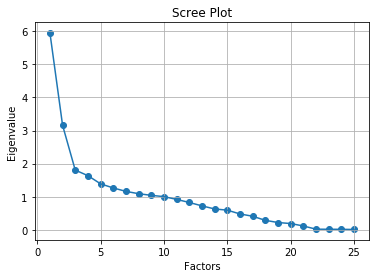

In [30]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

The scree plot method draws a straight line for each factor and its eigenvalues. Number eigenvalues greater than one considered as the number of factors.

Here, you can see again 10-factors eigenvalues are greater than one. It means we need to choose only 10 factors (or unobserved variables).

However something we can additionally, see is that after the first two, there really isnt a diffence in the eigenvalues. So really only the first two are significant. Therefore we will only choose **two factors**.

## Running factor analysis



In [31]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
numFactors = 2 # this will vary based on what you saw above
fa.analyze(df, numFactors, rotation="varimax")
fa.loadings

,Factor1,Factor2
water pH 1,0.119985,-0.021944
water pH 2,0.044566,0.000270
ground water level 1,0.799025,-0.094661
ground water level 2,-0.044711,0.022975
soil moisture 1,0.975765,-0.099547
soil moisture 2,0.987725,-0.085610
soil moisture 3,0.993876,-0.086575
motor monitor 1,0.155475,0.133223
motor monitor 2,0.052529,-0.083869
salinity I,-0.041657,0.030068


## Translating this into something we can understand a bit better

In [33]:

L = np.array(fa.loadings)
headings = list( fa.loadings.transpose().keys() )
factor_threshold = 0.25
for i, factor in enumerate(L.transpose()):
  descending = np.argsort(np.abs(factor))[::-1]
  contributions = [(np.round(factor[x],2),headings[x]) for x in descending if np.abs(factor[x])>factor_threshold]
  print('Factor %d:'%(i+1),contributions)

Factor 1: [(0.99, 'soil moisture 3'), (0.99, 'soil moisture 2'), (0.98, 'soil moisture 1'), (0.89, 'wall RH 1 I'), (0.86, 'wall RH 2 I'), (0.8, 'ground water level 1'), (0.52, 'wall RH 2 E'), (0.51, 'wall RH 1 E')]
Factor 2: [(0.97, 'wall RH 3 E'), (0.83, 'wall RH 1 E'), (0.83, 'wall RH 2 E'), (0.48, 'rain duration'), (0.45, 'rain intensity'), (-0.26, 'wind direction (radians)')]


**So what does this mean?**

## Solution




Factor 1 has high factor loadings for soil moisture, RH interior and exterior up to a certain height, as well as ground water only for the first sensor.



Factor 2 has high factor loadings for only external RH values all the way up and down the wall as well as rain duration, intensity, and wind direciton.

# Computing the variance

In [34]:
# Get variance of each factors
fa.get_factor_variance()

,Factor1,Factor2
SS Loadings,5.769659,2.929944
Proportion Var,0.230786,0.117198
Cumulative Var,0.230786,0.347984


Total 35% cumulative Variance explained by the 2 factors.

**Pros and Cons of Factor Analysis**

Factor analysis explores large dataset and finds interlinked associations. It reduces the observed variables into a few unobserved variables or identifies the groups of inter-related variables, which help the market researchers to compress the market situations and find the hidden relationship among consumer taste, preference, and cultural influence. Also, It helps in improve questionnaire in for future surveys. Factors make for more natural data interpretation.

Results of factor analysis are controversial. Its interpretations can be debatable because more than one interpretation can be made of the same data factors. After factor identification and naming of factors requires domain knowledge.